In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import process_data

In [5]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import process_data

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_fixed")
features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML


In [6]:
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data

training_data = process_data.load_data(interpolated_dir, 
                                       years = [2018, 2019, 2020, 2021, 2022], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win"
                                       )

validation_data = process_data.load_data(interpolated_dir, 
                                       years = [2023], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = True
                                       )

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = False
                                       )

Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2017
skipping  2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2021
Loading data for 2020
  Processing 255 CSV files in parallel with 8 workers...
  Completed processing 2020
Loading data for 2018
  Processing 255 CSV files in parallel with 8 workers...
  Completed processing 2018
Loading data for 2016
skipping  2016
Loading data for 2022
skipping  2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
skipping  2017
Loading data for 2019
skipping  2019
Loading 

In [12]:
training_data.keys()

dict_keys([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.175, 0.18, 0.185, 0.19, 0.195, 0.2, 0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.285, 0.29, 0.295, 0.3, 0.305, 0.31, 0.315, 0.32, 0.325, 0.33, 0.335, 0.34, 0.345, 0.35, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.4, 0.405, 0.41, 0.415, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47, 0.475, 0.48, 0.485, 0.49, 0.495, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.565, 0.57, 0.575, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.61, 0.615, 0.62, 0.625, 0.63, 0.635, 0.64, 0.645, 0.65, 0.655, 0.66, 0.665, 0.67, 0.675, 0.68, 0.685, 0.69, 0.695, 0.7, 0.705, 0.71, 0.715, 0.72, 0.725, 0.73, 0.735, 0.74, 0.745, 0.75, 0.755, 0.76, 0.7

In [26]:
modules_to_reload = [
    'models.xg_boost',
    'models.Model'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data

from models.xg_boost import setup_xgboost_models
other_features = [
            "home_has_possession", # Binary indicator
            "end.down",            # Down number (1-4, discrete)
            "home_timeouts_left",  # Discrete count (0-3)
            "away_timeouts_left",  # Discrete count (0-3)
        ]
numeric_features = [
    "score_difference",
    "relative_strength", 
    "end.yardsToEndzone", 
    "end.distance", 
]
models = setup_xgboost_models(training_data, validation_data, numeric_features = numeric_features, other_features = other_features, all_features = features, optimize_hyperparams=False, use_calibration=False)


Timestep 0.00%: Training Loss = 0.3436, Accuracy = 0.6564, Validation Loss = 0.2286, Validation Accuracy = 0.5932
Timestep 0.50%: Training Loss = 0.3366, Accuracy = 0.6634, Validation Loss = 0.2478, Validation Accuracy = 0.4839
Timestep 1.00%: Training Loss = 0.3338, Accuracy = 0.6662, Validation Loss = 0.2313, Validation Accuracy = 0.5902
Timestep 1.50%: Training Loss = 0.3517, Accuracy = 0.6483, Validation Loss = 0.2342, Validation Accuracy = 0.6146
Timestep 2.00%: Training Loss = 0.3432, Accuracy = 0.6568, Validation Loss = 0.2457, Validation Accuracy = 0.5467
Timestep 2.50%: Training Loss = 0.3495, Accuracy = 0.6505, Validation Loss = 0.2241, Validation Accuracy = 0.6234
Timestep 3.00%: Training Loss = 0.3291, Accuracy = 0.6709, Validation Loss = 0.2286, Validation Accuracy = 0.6267
Timestep 3.50%: Training Loss = 0.3403, Accuracy = 0.6597, Validation Loss = 0.2417, Validation Accuracy = 0.5357
Timestep 4.00%: Training Loss = 0.3333, Accuracy = 0.6667, Validation Loss = 0.2393, Val

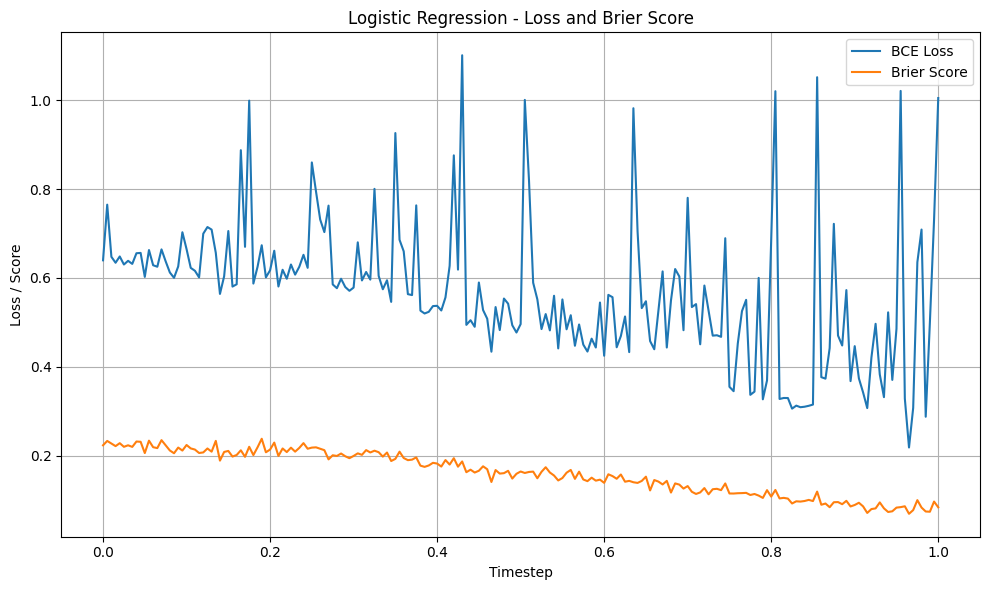

In [14]:
import process_data
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

x = process_data.plot_loss(models, test_data, "Logistic Regression")

In [7]:
%load_ext autoreload
%autoreload 2

In [24]:
model = models[0.99]
features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
data_point = [0.5, -4, 1, 1, 1, 1, 1, 1]
model.predict_proba([data_point])

array([[0.58823529, 0.41176471]])

In [ ]:
%reload_ext autoreload
from models.utils import SHAP_analysis


SHAP_analysis(models, training_data, test_data, "XGBoost", "shap_values/XGBoost", num_threads = 1)

Processing 201 timesteps (skipping 0 already done).


PermutationExplainer explainer: 277it [00:28,  6.72it/s]                         


Saved XGBoost_0.0.npz
Saved XGBoost_0.005.npz


PermutationExplainer explainer: 282it [00:21,  7.14it/s]                         


Saved XGBoost_0.01.npz


PermutationExplainer explainer: 307it [00:25,  7.47it/s]                         


Saved XGBoost_0.015.npz


PermutationExplainer explainer: 290it [00:12,  4.25it/s]                         


Saved XGBoost_0.02.npz


PermutationExplainer explainer: 316it [00:25,  7.75it/s]                         


Saved XGBoost_0.025.npz


PermutationExplainer explainer: 306it [00:24,  7.34it/s]                         


Saved XGBoost_0.03.npz


PermutationExplainer explainer: 319it [00:13,  4.03it/s]                         


Saved XGBoost_0.035.npz


PermutationExplainer explainer: 337it [00:16,  7.81it/s]                         


Saved XGBoost_0.04.npz


PermutationExplainer explainer: 312it [00:20,  8.29it/s]                         


Saved XGBoost_0.045.npz


PermutationExplainer explainer: 336it [00:22,  8.14it/s]                         


Saved XGBoost_0.05.npz


PermutationExplainer explainer: 365it [00:25,  8.68it/s]                         


Saved XGBoost_0.055.npz


PermutationExplainer explainer: 334it [00:22,  8.01it/s]                         


Saved XGBoost_0.06.npz


PermutationExplainer explainer: 335it [00:31,  7.43it/s]                         


Saved XGBoost_0.065.npz


PermutationExplainer explainer: 339it [00:37,  5.59it/s]                         


Saved XGBoost_0.07.npz


PermutationExplainer explainer: 343it [00:38,  6.66it/s]                         


Saved XGBoost_0.075.npz


PermutationExplainer explainer: 343it [00:27,  8.37it/s]                         


Saved XGBoost_0.08.npz


PermutationExplainer explainer: 335it [00:31,  7.43it/s]                         


Saved XGBoost_0.085.npz


PermutationExplainer explainer: 360it [00:21,  9.02it/s]                         


Saved XGBoost_0.09.npz


PermutationExplainer explainer: 358it [00:34,  7.33it/s]                         


Saved XGBoost_0.095.npz


PermutationExplainer explainer: 354it [00:29,  7.87it/s]                         


Saved XGBoost_0.1.npz


PermutationExplainer explainer: 343it [00:47,  5.51it/s]                         


Saved XGBoost_0.105.npz


PermutationExplainer explainer: 347it [00:32,  7.16it/s]                         


Saved XGBoost_0.11.npz


PermutationExplainer explainer: 342it [00:28,  7.87it/s]                         


Saved XGBoost_0.115.npz


PermutationExplainer explainer: 340it [00:38,  6.71it/s]                         


Saved XGBoost_0.12.npz


PermutationExplainer explainer: 352it [00:23,  8.69it/s]                         


Saved XGBoost_0.125.npz


PermutationExplainer explainer: 319it [00:35,  6.03it/s]                         


Saved XGBoost_0.13.npz


PermutationExplainer explainer: 335it [00:53,  5.48it/s]                         


Saved XGBoost_0.135.npz


PermutationExplainer explainer:  66%|██████▋   | 234/352 [00:28<00:14,  8.15it/s]

KeyboardInterrupt: 

PermutationExplainer explainer:  67%|██████▋   | 235/352 [00:28<00:20,  5.70it/s]

PermutationExplainer explainer:  86%|████████▌ | 302/352 [00:36<00:08,  5.71it/s]Exception ignored in: <function tqdm.__del__ at 0x1572b1dc0>
Traceback (most recent call last):
  File "/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL_env/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL_env/lib/python3.9/site-packages/tqdm/std.py", line 1302, in close
    self.display(pos=0)
  File "/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL_env/lib/python3.9/site-packages/tqdm/std.py", line 1495, in display
    self.sp(self.__str__() if msg is None else msg)
  File "/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL_env/lib/python3.9/site-packages/tqdm/std.py", line 459, in print_status
    fp_write('\r' + s + (' ' * max(last_len[0] - len_s, 0)))
  File "/Users/aly/Documents/University_of_Waterloo/Winter 2025/Res

In [25]:
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from process_data import write_predictions

write_predictions(models, interpolated_dir, [2024], 0, features, replace_nan_val = 0, phat_b = "xgboost_phat_b")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Processed file:  game_401671831.csv
Processed file:  game_401671825.csv
Processed file:  game_401671819.csv
Processed file:  game_401671762.csv
Processed file:  game_401671776.csv
Processed file:  game_401671789.csv
Processed file:  game_401671788.csv
Processed file:  game_401671777.csv
Processed file:  game_401671763.csv
Processed file:  game_401671818.csv
Processed file:  game_401671824.csv
Processed file:  game_401671830.csv
Proces